| ![EEW logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/main/Jupyter%20instructions/eew.jpg?raw=true) | ![EDGI logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/main/Jupyter%20instructions/edgi.png?raw=true) |
|---|---|


#### This notebook is licensed under GPL 3.0.
#### The notebook was collaboratively authored by the Environmental Data & Governance Initiative (EDGI) following [our authorship protocol](https://docs.google.com/document/d/1CtDN5ZZ4Zv70fHiBTmWkDJ9mswEipX6eCYrwicP66Xw/)
#### For more information about this project, visit [our website](https://www.environmentalenforcementwatch.org/)

## How to Run
![Instructions for running a Jupyter Notebook](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/main/overall_instructions.png?raw=true)

Watch a demo of this notebook:

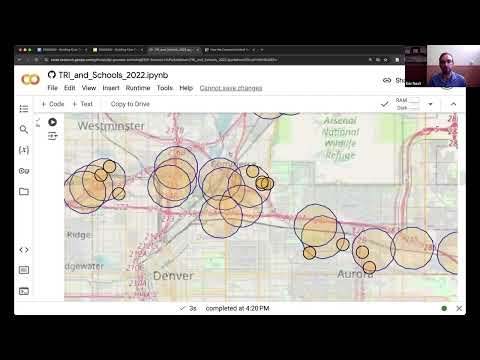

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('xlQJNX8JbEg')

## Get ready

In [ ]:
!pip install ECHO_modules &>/dev/null; # EDGI's existing code for accessing EPA data
import geopandas, folium # For mapping purposes
from IPython.core.display import HTML # For pretty output
import warnings
warnings.filterwarnings("ignore") # Ignore warnings we already know about...

## Pick a place
Our analysis will zoom in and show what's going on in a county of your choosing (and, at the end, a specific school you select).

First, run the following code and name the state the county is in. After you select the state, you can go to the next cell.

In [ ]:
from ECHO_modules.utilities import show_pick_region_widget, show_state_widget

state_widget = show_state_widget()

Dropdown(description='State:', options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI'…

Run this next cell of code to pick the specific county.

In [ ]:
county_widget = show_pick_region_widget(type="County", state_widget=state_widget, multi=False)

Dropdown(description='County:', options=('ADAMS', 'ALAMOSA', 'ANNE ARUNDEL', 'ARAPAHOE', 'ARCHULETA', 'BACA', …

## Here are the public schools in your selected county

We load data on schools from the National Center for Education Statistics: https://data-nces.opendata.arcgis.com/datasets/nces::public-school-characteristics-2022-23/about This does not include private schools or post-secondary schools (colleges and universities).

This cell may take some time to load since there are many schools in the country!

In [ ]:
# Helper code
## For getting data
import pandas
import zipfile, requests, io
from pathlib import Path
## For mapping
from ECHO_modules.get_data import get_spatial_data
from ECHO_modules.geographies import spatial_tables
from ECHO_modules.utilities import mapper, bivariate_map

# Get the schools data
## Check if we have the data already or not
ps = Path("PublicSchools")
if ps.is_dir():
  pass
else:
  r = requests.get("https://github.com/edgi-govdata-archiving/EEW-Schools-HAPs/raw/main/Public_School_Characteristics_2022-23.csv.zip") # Get a copy of the data we've made
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall("PublicSchools") # Unzip the data file
  # Load the schools data
  schools = pandas.read_csv("/content/PublicSchools/Public_School_Characteristics_2022-23.csv") # Load the data
  schools = geopandas.GeoDataFrame(schools, geometry=geopandas.points_from_xy(schools["LONCOD"], schools["LATCOD"], crs=4269)) # Load the data as a geographic file with lat/long coordinates
  schools.to_crs(crs='esri:102003', inplace=True) # Transform coordinates to equal area projection for analysis

# Get spatial data
county, state = get_spatial_data(region_type="County", states=[state_widget.value], spatial_tables=spatial_tables, region_filter=county_widget.value.title()) # Get county shape
county.to_crs('esri:102003', inplace=True) # Project to match schools' projection

# Filter schools to this county, for mapping purposes
county_schools = geopandas.clip(schools, county)

# Make a map
county_schools["FAC_LAT"] = county_schools.geometry.to_crs(4326).y # For mapping, translate to WGS 84
county_schools["FAC_LONG"] = county_schools.geometry.to_crs(4326).x # For mapping, translate to WGS 84
bivariate_map(county, county_schools, no_text=False, points_fields=['SCH_NAME',], points_aliases=['School Name:',], show_marker=False) #county, county_schools, no_text=True) #(

## Here are facilities that reported releasing Hazardous Air Pollutants in your selected county
We get the 2022 Toxic Releases Inventory (TRI)-reported air emissions from EDGI's Copy of EPA Data. 2022 is the latest year available for the TRI. See here for more information: https://echo.epa.gov/tools/data-downloads/air-emissions-download-summary

In [ ]:
# Get TRI data
from ECHO_modules.utilities import get_echo_data, get_facs_in_counties
sql = 'select * from "TOXIC_RELEASES_MVIEW" where "REPORTING_YEAR" = \'2022\''
all_records = get_echo_data(sql)
all_records = geopandas.GeoDataFrame(all_records, geometry=geopandas.points_from_xy(all_records["FAC_LONG"], all_records["FAC_LAT"], crs=4269)) # Make the records mappable
all_records.to_crs(crs='esri:102003', inplace=True) # Project to equal area projection

# HAPs
tri_chemicals = pandas.read_excel("https://www.epa.gov/system/files/documents/2023-09/TRI%20Chemical%20List%20Groupings%20for%20Analysis%20Sept.%202023%20.xlsx")
haps = tri_chemicals.loc[(tri_chemicals["Hazardous Air Pollutants"]=="X") & (tri_chemicals['2020 Core Chemicals']=="X")] # Make sure the chemical is still a HAP, not a previous HAP
haps = haps[['Chemical', 'OSHA Carcinogens', 'OTHER_HEALTH_EFFECTS', 'BODY_WEIGHT', 'CARDIOVASCULAR', 'DERMAL', 'DEVELOPMENTAL', 'ENDOCRINE', 'GASTROINTESTINAL', 'HEMATOLOGICAL', 'HEPATIC', 'IMMUNOLOGICAL', 'METABOLIC', 'MUSCULOSKELETAL', 'NEUROLOGICAL', 'OCULAR', 'OTHER_SYSTEMIC', 'RENAL', 'REPRODUCTIVE', 'RESPIRATORY', 'NO_HEALTH_EFFECTS', 'ACUTE', 'INTERMEDIATE', 'CHRONIC']]
haps.set_index("Chemical", inplace=True)
list_of_haps = list(haps.index.unique()) # A list of HAPs

# Create a list of HAP-releasing facilities
tri_haps_2022 = all_records.loc[all_records['POLLUTANT_NAME'].isin(list_of_haps)]
tri_haps_2022 = tri_haps_2022.loc[tri_haps_2022["ANNUAL_EMISSION"]>0] # Sometimes facilities report 0 emissions, so we remove those here
tri_haps_2022 = tri_haps_2022.drop_duplicates(subset="REGISTRY_ID") # Drop duplicate rows (facilities reporting multiple pollutants) to just get one row per facility (registry ID)
tri_haps_2022_in_this_county = geopandas.clip(tri_haps_2022, county) # Clip to just those facilities in the county

# Map
bivariate_map(county, tri_haps_2022_in_this_county, no_text=False, points_fields=['FAC_NAME',], points_aliases=['Facility Name:',], show_marker=False)

## Determine which public schools are within 1 mile of facilities releasing Hazardous Air Pollutants

In the map that follows, the larger orange circles represent the 1 mile buffers around Hazardous Air Pollutant-releasing facilities. Every facility within 1 mile of the county border is included. The smaller orange circles are public schools in the county.

In [ ]:
# Create a 1 mile buffer around HAP facilities
tri_haps_2022["buffer"] = tri_haps_2022["geometry"].buffer(1609) # 1609 meters = 1 mile.
tri_haps_2022.set_geometry("buffer", inplace=True)

# Map this for the selected county
close_schools = schools.sindex.query_bulk(tri_haps_2022["buffer"], predicate="contains")[1] # Close schools are those that are contained by the buffer we just created
schools_by_tri_haps_2022 = schools.loc[schools.index.isin(close_schools)] # Look up detailed school information
this_county_schools_by_tri_haps_2022 = geopandas.clip(schools_by_tri_haps_2022, county) # This county's schools near HAP facilities
this_county_schools_by_tri_haps_2022["FAC_LAT"] = this_county_schools_by_tri_haps_2022.geometry.to_crs(4326).y # For mapping, translate to WGS 84
this_county_schools_by_tri_haps_2022["FAC_LONG"] = this_county_schools_by_tri_haps_2022.geometry.to_crs(4326).x # For mapping, translate to WGS 84
this_county_buffer = tri_haps_2022[tri_haps_2022["buffer"].intersects(county["geometry"][0])] # Facilities whose buffer intersects the county
bivariate_map(this_county_buffer[["FAC_NAME", "buffer"]], this_county_schools_by_tri_haps_2022, no_text=False,
              region_fields=["FAC_NAME"], region_aliases=["Facility"], points_fields=['SCH_NAME'],
              points_aliases=['School Name:'], show_marker=False)

## What do we know about these schools and facilities?
We'll ask and answer the following questions for both the entire country and the selected county:
* How many schools are within 1 miles of facilities that in 2022 reported releasing HAPs to TRI?
* What percent of all public schools is this?
* How many HAP-releasing facilities is this?
* How much pollution are children potentially exposed to? What kind of pollution / with what potential health effects?
* Who attends schools near HAP emitters?

In [ ]:
def stats(these_schools, all_schools, facilities, scale):
  display(HTML("<h2>"+scale+"</h2>"))
  display(HTML("<h3>How many schools are near facilities? </h3>" + "{:,}".format(these_schools.shape[0])))
  display(HTML("<h3>What percent of public schools nationwide or in the county is this? </h3>" + str(round(100*(these_schools.shape[0]/all_schools.shape[0]))) + "%"))
  # Find the facilities with schools in their buffer. We do a spatial join of facilities and schools,
  # pairing each facility with the school(s) in its buffer
  # This produces extra rows (each row = a facility and a nearby school)
  # so we drop extra rows that indicate facilities with multiple schools nearby
  close_facs = tri_haps_2022.set_geometry("buffer").sjoin(these_schools).drop_duplicates(subset="REGISTRY_ID")
  display(HTML("<h3>How many HAP-releasing facilities account for this? </h3>" + "{:,}".format(close_facs.shape[0])))
  display(HTML("<h3>What percent of HAP-releasing facilities nationwide or in/near the county is this? </h3>" + str(round(100*(close_facs.shape[0]/ facilities.shape[0]))) + "%"))
  return close_facs # Return this data for later use

county_close_facs = stats(this_county_schools_by_tri_haps_2022, county_schools, this_county_buffer, "In "+county_widget.value.title()+" County " + state_widget.value)
national_close_facs = stats(schools_by_tri_haps_2022, schools, tri_haps_2022, "Nationwide")

How much pollution are children potentially exposed to? What kind of pollution / with what potential health effects? Here are the top 15 HAPs reported released in terms of total weight (pounds):

In [ ]:
def top_haps(these_schools, close_by, scale):
  display(HTML("<h2>"+scale+"</h2>"))
  list_of_closefacs = list(close_by["REGISTRY_ID"].unique()) # Get a list of the IDs of facilities close to schools
  pollution = tri_haps_2022.loc[tri_haps_2022["REGISTRY_ID"].isin(list_of_closefacs)] # Look up their pollution reports to TRI
  pandas.options.display.float_format = '{:,.2f}'.format
  top15 = pollution.groupby(by=["POLLUTANT_NAME"])[["ANNUAL_EMISSION"]].sum().sort_values(by="ANNUAL_EMISSION", ascending=False).head(15).join(haps) # Sum these up and sort them
  top15 = top15.fillna(" ")
  display(top15)
  return top15 # Return for later use

top15_county = top_haps(county_schools, county_close_facs, "In "+county_widget.value.title()+" County " + state_widget.value)
top15_national = top_haps(schools, national_close_facs, "Nationwide")

,ANNUAL_EMISSION,OSHA Carcinogens,OTHER_HEALTH_EFFECTS,BODY_WEIGHT,CARDIOVASCULAR,DERMAL,DEVELOPMENTAL,ENDOCRINE,GASTROINTESTINAL,HEMATOLOGICAL,...,NEUROLOGICAL,OCULAR,OTHER_SYSTEMIC,RENAL,REPRODUCTIVE,RESPIRATORY,NO_HEALTH_EFFECTS,ACUTE,INTERMEDIATE,CHRONIC
POLLUTANT_NAME,,,,,,,,,,,,,,,,,,,,,
Toluene,"13,573.00",,X,,,,,,,,...,X,X,,X,,X,,X,X,X
Styrene,"4,633.00",X,X,,,,,,,X,...,X,X,,,,X,,X,,X
Methanol,"3,436.00",,X,,,,X,,,,...,X,,X,,,,,X,,X
"Toluene-2,4-diisocyanate",155.54,X,X,,,,,,,,...,,,,,,X,,X,,X
Ethylene glycol,49.00,,X,,,,X,,,,...,,,,X,,X,,X,X,X
Lead compounds,1.01,,X,,X,,X,,,X,...,X,,,X,X,,,,,
Chromium,0.81,,,,,,,,,,...,,,,,,,,,,


,ANNUAL_EMISSION,OSHA Carcinogens,OTHER_HEALTH_EFFECTS,BODY_WEIGHT,CARDIOVASCULAR,DERMAL,DEVELOPMENTAL,ENDOCRINE,GASTROINTESTINAL,HEMATOLOGICAL,...,NEUROLOGICAL,OCULAR,OTHER_SYSTEMIC,RENAL,REPRODUCTIVE,RESPIRATORY,NO_HEALTH_EFFECTS,ACUTE,INTERMEDIATE,CHRONIC
POLLUTANT_NAME,,,,,,,,,,,,,,,,,,,,,
Styrene,"8,628,929.63",X,X,,,,,,,X,...,X,X,,,,X,,X,,X
Methanol,"6,212,974.08",,X,,,,X,,,,...,X,,X,,,,,X,,X
Carbon disulfide,"3,091,161.94",,X,,,,X,,,,...,X,,,,X,,,X,,X
Toluene,"2,641,687.53",,X,,,,,,,,...,X,X,,X,,X,,X,X,X
Methyl isobutyl ketone,"752,134.74",X,X,X,,,X,,,,...,,,,,X,,,,,X
Formaldehyde,"490,649.42",X,X,X,,,,,X,,...,,X,,,,X,,X,X,X
Methyl methacrylate,"373,004.67",,X,,,,,,,,...,,,,,,X,,,,X
Ethylene glycol,"362,901.46",,X,,,,X,,,,...,,,,X,,X,,X,X,X
1-Bromopropane,"359,573.48",X,X,,,,,,,,...,X,,,,X,,,X,X,X


Because toxicants vary in their mass, ranking them in terms of weight can be misleading. Another approach would be to look at how commonly they are reported released.

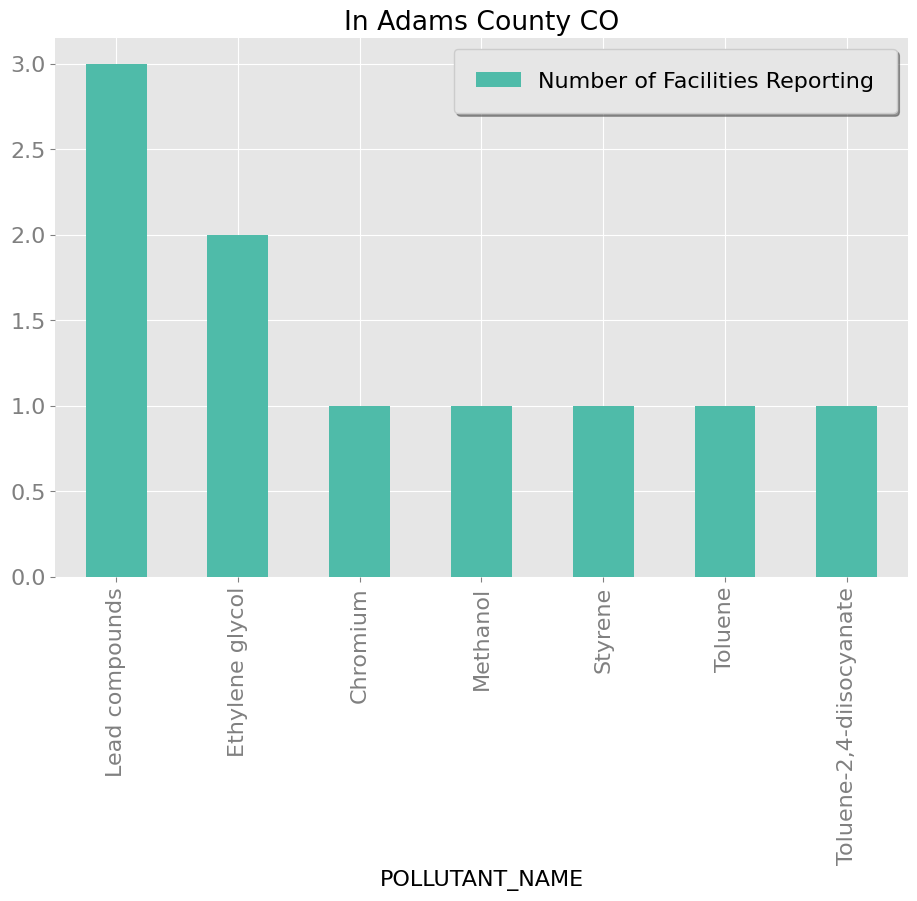

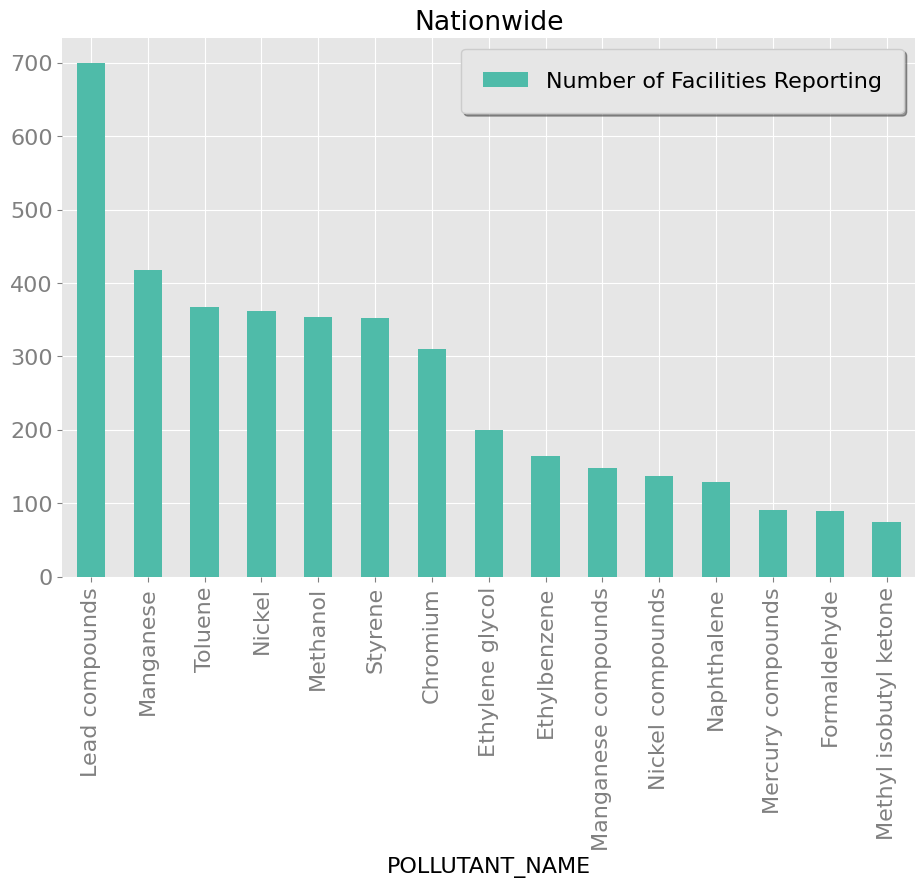

In [ ]:
def most_common(close_by, scale):
  #display(HTML("<h2>"+scale+"</h2>"))
  list_of_closefacs = list(close_by["REGISTRY_ID"].unique())
  pollution = tri_haps_2022.loc[tri_haps_2022["REGISTRY_ID"].isin(list_of_closefacs)]
  pollution_summary = pollution.groupby(by=["POLLUTANT_NAME"])[["REGISTRY_ID"]].nunique().sort_values(by="REGISTRY_ID", ascending=False).head(15)
  pollution_summary.rename(columns={"REGISTRY_ID": "Number of Facilities Reporting"}, inplace=True)
  p = pollution_summary.plot.bar(figsize=(11,7))
  p.set_title(scale)
  return pollution_summary # Return for later use

county_pollution_summary = most_common(county_close_facs, "In "+county_widget.value.title()+" County " + state_widget.value)
national_pollution_sumamry = most_common(national_close_facs, "Nationwide")

We will access other data from the National Center for Education Statistics in order to evaluate what kinds of students attend schools near HAPs emitters.

First, how many students qualify for free or reduced-price lunch?

In [ ]:
def who_attends(these_schools, all_schools, scale):
  display(HTML("<h2>"+scale+"</h2>"))
  display(HTML("<h3>How many students are qualified for free/reduced price lunch in schools near emitters of HAPs? </h3>" + "{:,}".format(these_schools["TOTFRL"].sum())))
  display(HTML("<h3>What percent of students in schools near HAP-relasing facilities qualify for free/reduced price lunch? </h3>" + "{:,.2f}".format(100* (these_schools["TOTFRL"].sum()/these_schools["TOTAL"].sum()))+ "%"))
  not_near = all_schools.loc[~all_schools["NCESSCH"].isin(list(these_schools['NCESSCH'].unique()))]
  display(HTML("<h3>What percent of students in schools NOT near HAP-relasing facilities qualify for free/reduced price lunch? </h3>" + "{:,.2f}".format(100* (not_near["TOTFRL"].sum()/not_near["TOTAL"].sum()))+ "%"))
  return not_near # Return for later use

not_near_county = who_attends(this_county_schools_by_tri_haps_2022, county_schools, "In "+county_widget.value.title()+" County " + state_widget.value)
not_near_national = who_attends(schools_by_tri_haps_2022, schools, "Nationwide")

Finally, we'll compare Census measures of students' race at schools near HAPs with schools NOT near HAPs.

In [ ]:
demos = {
"AM": 'American Indian or Alaska Native',
"AS": 'Asian',
"BL": 'Black or African American',
"HP": 'Native Hawaiian or Other Pacific Islander',
"HI": 'Hispanic/Latino',
"TR": 'Two or more races',
"WH": 'White'
} # List of Census demographic measures

def census(these_schools, other_schools, scale):
  display(HTML("<h2>"+scale+"</h2>"))
  near_summary = 100 * (these_schools[list(demos.keys())].sum() / these_schools["TOTAL"].sum() )
  not_near_summary = 100 * (other_schools[list(demos.keys())].sum()/ other_schools["TOTAL"].sum() )
  display(pandas.DataFrame([near_summary.values,not_near_summary.values], columns=demos.values(), index=["Percent of Students in Schools Near Facilities Releasing HAPs", "Percent of Students in Other Schools"]).transpose())

census(this_county_schools_by_tri_haps_2022, not_near_county, "In "+county_widget.value.title()+" County " + state_widget.value)
census(schools_by_tri_haps_2022, not_near_national, "Nationwide")

,Percent of Students in Schools Near Facilities Releasing HAPs,Percent of Students in Other Schools
American Indian or Alaska Native,0.44,0.50
Asian,5.66,3.84
Black or African American,4.31,2.70
Native Hawaiian or Other Pacific Islander,0.53,0.25
Hispanic/Latino,60.43,58.64
Two or more races,3.88,3.63
White,24.74,30.44


,Percent of Students in Schools Near Facilities Releasing HAPs,Percent of Students in Other Schools
American Indian or Alaska Native,0.64,1.01
Asian,4.71,5.46
Black or African American,17.22,14.51
Native Hawaiian or Other Pacific Islander,0.35,0.38
Hispanic/Latino,32.00,28.24
Two or more races,4.80,4.89
White,38.47,44.69


## Look Up Your Own School
Select from a list of schools in the county you previously selected, then see the above statistics calculated for it...

In [ ]:
list_of_schools = list(county_schools['SCH_NAME'])
list_of_schools.sort()

from ipywidgets import widgets

your_school = widgets.Dropdown(
    options=list_of_schools,
    description='School:',
    disabled=False,
)
your_school

Dropdown(description='School:', options=('27J Online Academy', 'Academy High School', 'Academy of Charter Scho…

In [ ]:
this_school = county_schools.loc[county_schools["SCH_NAME"] == your_school.value]
display(HTML("<h2>"+your_school.value+"</h2>"))

# Is this school near a HAP-releasing facility?
is_it_near = this_county_schools_by_tri_haps_2022.loc[this_county_schools_by_tri_haps_2022['NCESSCH'].isin(this_school['NCESSCH'].values)]
if not is_it_near.empty:
  is_it_near = "Yes"
else:
  is_it_near = "No"
display(HTML("<h3>Is it within 1 mile of a HAP-releasing facility? </h3>" + is_it_near))

# Proximity - what is the closest HAP releasing facility?
closest = geopandas.sjoin_nearest(this_school, tri_haps_2022.set_geometry("geometry"), distance_col="distances", how="right")
closest["distances"] = (closest["distances"]/1000) * 0.621371
most_close = closest.loc[closest["distances"]<=5]
if most_close.empty:
  most_close = closest.sort_values(by = "distances").head(10)
display(HTML("<h3>How far is the school from the closest HAP-releasing facility? </h3>" + str(round(most_close["distances"].values[0],1)) + " miles"))
display(HTML("<h3>How many HAP-releasing facilities are within 5 miles? </h3>" + str(most_close.shape[0])))

# Map school and closest 10 HAP-releasing facilities (within 5 miles)
most_close = geopandas.GeoDataFrame(
    most_close, geometry=geopandas.points_from_xy(most_close["FAC_LONG_right"], most_close["FAC_LAT_right"]), crs=4269
)
most_close.to_crs('esri:102003', inplace=True)

m = folium.Map()

ts = folium.GeoJson(
  this_school,
  tooltip=this_school["SCH_NAME"].values[0]

).add_to(m)

c = folium.GeoJson(
  most_close[["FAC_NAME", "geometry"]],
  marker=folium.CircleMarker(radius=14, fill_color="orange", fill_opacity=0.4, color="black", weight=1),
  tooltip=folium.GeoJsonTooltip(fields=["FAC_NAME"])
).add_to(m)

bounds = m.get_bounds()
m.fit_bounds(bounds)

m

What air pollutants were reported released from the facility/ies closest to this school in 2022?

In [ ]:
display(HTML("<h2>"+your_school.value+"</h2>"))
tri_haps_2022.loc[tri_haps_2022["REGISTRY_ID"].isin(most_close["REGISTRY_ID"].values)].groupby(by=["POLLUTANT_NAME"])[["ANNUAL_EMISSION"]].sum().sort_values(by="ANNUAL_EMISSION", ascending=False).join(haps).fillna(" ")

,ANNUAL_EMISSION,OSHA Carcinogens,OTHER_HEALTH_EFFECTS,BODY_WEIGHT,CARDIOVASCULAR,DERMAL,DEVELOPMENTAL,ENDOCRINE,GASTROINTESTINAL,HEMATOLOGICAL,...,NEUROLOGICAL,OCULAR,OTHER_SYSTEMIC,RENAL,REPRODUCTIVE,RESPIRATORY,NO_HEALTH_EFFECTS,ACUTE,INTERMEDIATE,CHRONIC
POLLUTANT_NAME,,,,,,,,,,,,,,,,,,,,,
Methanol,"1,353.00",,X,,,,X,,,,...,X,,X,,,,,X,,X
Toluene,600.19,,X,,,,,,,,...,X,X,,X,,X,,X,X,X
"N,N-Dimethylformamide",500.00,X,X,,,,,,X,,...,,,,,,X,,,,X
Naphthalene,22.00,X,X,X,,,,,,,...,X,,,,,X,,X,X,X
Nickel,20.00,X,X,,,,,,,X,...,,,,,,X,,X,X,X
Ethylbenzene,6.00,X,X,,,,X,X,,,...,X,,,X,,,,X,X,X
Chromium,0.81,,,,,,,,,,...,,,,,,,,,,
Lead compounds,0.54,,X,,X,,X,,,X,...,X,,,X,X,,,,,


What are the characteristics of this school?

In [ ]:
display(HTML("<h2>"+your_school.value+"</h2>"))
display(HTML("<h3>How many students are qualified for free/reduced price lunch in this school? </h3>" + "{:,}".format(this_school["TOTFRL"].sum())))
display(HTML("<h3>What percent of students qualify for free/reduced price lunch? </h3>" + "{:,.2f}".format(100* (this_school["TOTFRL"].sum()/this_school["TOTAL"].sum()))+ "%"))
display(HTML("<h3>What percent of students in all public schools in this county qualify for free/reduced price lunch? </h3>" + "{:,.2f}".format(100* (county_schools["TOTFRL"].sum()/county_schools["TOTAL"].sum()))+ "%"))

this_summary = 100 * (this_school[list(demos.keys())].sum() / this_school["TOTAL"].sum() )
county_summary = 100 * (county_schools[list(demos.keys())].sum()/ county_schools["TOTAL"].sum() )
pandas.DataFrame([this_summary.values,county_summary.values], columns=demos.values(), index=["Percent of Students in Selected School", "Percent of Students in Other Schools in This County"]).transpose()

,Percent of Students in Selected School,Percent of Students in Other Schools in This County
American Indian or Alaska Native,0.73,0.49
Asian,0.00,4.03
Black or African American,1.82,2.87
Native Hawaiian or Other Pacific Islander,0.00,0.28
Hispanic/Latino,86.00,58.83
Two or more races,1.09,3.65
White,10.36,29.84
